## R4ML: Data Preparation and Dimensionality reduction

### (Part 2)

#####    [Alok Singh](https://github.com/aloknsingh/)

### Contents

#### &nbsp;&nbsp;  1. Introduction
#### &nbsp;&nbsp;  2. Data Preparation and Pre-processing
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.1. Why to do data preparation and pre-processing?
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.2. Typical time spend by a Data Scientist.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.3. How does R4ML Address Data Preparation and Pre-Processing?
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.4. An Example of Data Pre-Processing.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.5. Next steps for Advanced Users.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2.6. Summary of Data Preparation
#### &nbsp;&nbsp;  3 Dimensionality Reduction
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.1. What is Dimensionality Reduction? 
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.2. Why is Dimensionality Reduction Useful?
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.3. R4ML for Dimensionality Reduction of Big data with an example.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.4. Summary of Dimensionality Reduction.
##### &nbsp;&nbsp;  4. Summary and next steps ...


## 1. Introduction

In our first notebook we received an introduction to R4ML and conducted some exploratory data analysis with it.
In this section, we will go over the typical operations a data scientist performs while cleaning and pre-processing the input data. Now, we will look into dimensionality reduction, first starting out with the boiler plate code from Part I for the purposes of loading etc.
The following code is copy pasted from part I:

In [1]:
library(R4ML)
library(SparkR)

r4ml.session()
# read the airline dataset
airt <- airline
# testing, we just use the small dataset
airt <- airt[airt$Year >= "2007",]
airt <- airline
# testing, we just use the small dataset
airt <- airt[airt$Year >= "2007",]
air_hf <- as.r4ml.frame(airt)

airs <- r4ml.sample(air_hf, 0.1)[[1]]


#
 total_feat <- c(
  "Year", "Month", "DayofMonth", "DayOfWeek", "DepTime","CRSDepTime","ArrTime",
  "CRSArrTime", "UniqueCarrier", "FlightNum", "TailNum", "ActualElapsedTime",
  "CRSElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Origin", "Dest",
  "Distance", "TaxiIn", "TaxiOut", "Cancelled", "CancellationCode",
  "Diverted", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay",
  "LateAircraftDelay")
#categorical features

#"Year", "Month", "DayofMonth", "DayOfWeek",
cat_feat <- c("UniqueCarrier", "FlightNum", "TailNum", "Origin", "Dest",
  "CancellationCode", "Diverted")

numeric_feat <- setdiff(total_feat, cat_feat)
# these features have no predictive power as it is uniformly distributed i.e less information
unif_feat <- c("Year", "Month", "DayofMonth", "DayOfWeek")
# these are the constant features and we can ignore without much difference in output
const_feat <- c("WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay")

col2rm <- c(unif_feat, const_feat, cat_feat)

rairs <- SparkR::as.data.frame(airs)
airs_names <- names(rairs)
rairs2_names <- setdiff(airs_names, col2rm) 
rairs2 <- rairs[, rairs2_names]

# first we will create the imputation maps
# we impute all the columns
airs_ia <- total_feat
# imputation methods
airs_im <- lapply(total_feat,
               function(feat) {
                 v= if (feat %in% numeric_feat) {"global_mean"} else {"constant"}
                 v
               })
# convert to vector
airs_im <- sapply(airs_im, function(e) {e})
#imputation values
airs_iv <- setNames(as.list(rep("CAT_NA", length(cat_feat))), cat_feat)
na.cols<- setdiff(total_feat, airs_ia)

# we cache the output so that not to re-exe DAG
dummy <- cache(airs)



Warning message:
“WARN[R4ML]: Reloading SparkR”Loading required namespace: SparkR

  _______   _    _    ____    ____  _____
 |_   __ \ | |  | |  |_   \  /   _||_   _|    
   | |__) || |__| |_   |   \/   |    | |      
   |  __ / |____   _|  | |\  /| |    | |   _  
  _| |  \ \_   _| |_  _| |_\/_| |_  _| |__/ | 
 |____| |___| |_____||_____||_____||________| 
 

[R4ML]: version 0.8.0
Warning message:
“no function found corresponding to methods exports from ‘R4ML’ for: ‘collect’”
Attaching package: ‘SparkR’

The following object is masked from ‘package:R4ML’:

    predict

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Warning message:
“WARN[R4ML]:  driver.memory not defined. Defaulting to 2G”Spark package found in SPARK_HOME: /usr/

Launching java with spark-submit command /usr/local/src/spark21master/spark/bin/spark-submit --jars /gpfs/global_fs01/sym_shared/YPProdSpark/user/sa28-9716de71e3ac0f-9ac12ed2939a/R/libs/R4ML/java/SystemML.jar  --driver-memory "2G" sparkr-shell /gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/notebook/tmp/RtmpRFWwxn/backend_portbc584741b491 


[R4ML]: Default log level will be set to 'INFO'
[R4ML]: To change call r4ml.setLogLevel(NewLevel)
INFO[calc num partitions]: 48 partitions
INFO[as.r4ml.frame]: repartitioning an object of size: 2448976 into 48 partitions


## 2. Data Preparation and Pre-processing?

### 2.1. Why data preparation and pre-processing?
 
* Real life data has many missing values.
* Outliers are present, which will affect the model predictive powers.
* Data may be corrupted.
* Certain features (columns) of data are expressed as strings but most of the ML algorithms, works in the double and integers. 
* Without pre-processing, the analytics power of the models is reduced significantly.



### 2.2. Typical time spent by a Data Scientist.

Here is the detail. And as we can see that there is the need for unified API for doing the data preparation to simply the journey of data scientist. 

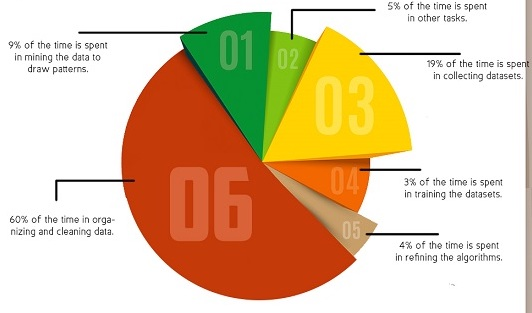

### 2.3. How does R4ML Address Data Preparation and Pre-Processing?

 * R4ML provides a unified API to run the various data preprecessing tasks from one entry point. 
 * The user can also run the individual data preprocessing via the r4ml.frame and r4ml.matrix api.
 * Its API is more closer to the model of [R's caret](http://caret.r-forge.r-project.org/) package.


 The function is called **r4ml.ml.preprocess** and it supports all major pre-processing tasks, feature transformation routines e.g 
 R4ML supports all the major pre-processing task:
 
| **Method**         |** R4ML options **| **Description**     | 
| :----------------- |:-------------|:-------------|
| **NA Removal **    | imputationMethod, imputationValues, omit.na | this options let one remove the missing data or user can substitute with the constant or with the mean (if it is numeric)|
| **Binning **       | binningAttrs, numBins| One of the typical use case of binning is say we have the height of the people in feet and inches and if we only care about three top level category i.e short , medium and tall, user can use this option      |
| **Scaling and Centering** | scalingAttrs| Most of the algo’s prediction power or the result become better if it is normalized i.e substract the mean and then divide it by stddev.      |
| **Encoding (Recode)** | recodeAttrs| Since most of the machine learning algorithm is the matrix based linear algebra. Many times the categorical columns have inherit order in it like height or shirt_size, it options provide user the ability to encode those string columns into the ordinal categorical numeric value     |
| **Encoding (OneHot or DummyCoding)** | dummyCodeAttrs | when categorical columns have no inherit orders like people’s race or states they lives in, in that case, we would like to do one hot encoding for those.
      |





## 2.4. An Example of Data Processing.

We already have the airs r4ml.frame and we will first cache it (to improve the performance we need to cache before heavy lifting).


In the next cell, we regroup the various columns into the above methods
and in the cell after, that we run the r4ml.ml.preprocess.


In [2]:
airs_t_res <- r4ml.ml.preprocess(
    airs,
    dummycodeAttrs = c(),
    binningAttrs = c(), numBins=4,
    missingAttrs = airs_ia,
    imputationMethod = airs_im,
    imputationValues = airs_iv,
    omit.na=na.cols, # we remove all the na, this is just the dummy
    recodeAttrs=cat_feat # recode all the categorical features
  )


  # the transformed data frame
  airs_t <- airs_t_res$data
  # the relevant metadata list
  airs_t_mdb <- airs_t_res$metadata

  # cache the transformed data
  dummy <- cache(airs_t)
  showDF(airs_t, n = 2)

INFO[r4ml.ml.preprocess]: running proxy.omit.na
INFO[r4ml.ml.preprocess]: running proxy.impute
INFO[r4ml.ml.preprocess]: running proxy.normalize
INFO[r4ml.ml.preprocess]: running proxy.binning
INFO[r4ml.ml.preprocess]: running proxy.recode
INFO[r4ml.ml.preprocess]: running proxy.onehot


+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    9|        21|        5|   1759|      1800|   1927|      1945|            2|      655

### 2.5. Next steps for Advanced Users.

All the values are numeric now and we are ready for the next steps of the pipeline. However, we want to end this topic with a note to the user that in using the custom DML (explained later), the advanced user can write the advanced data pre-processing step independently. 

Other data pre-processing steps, that are typically done:

 ** Input data transformation (Box Cox)**
We saw in the previous section that the input data when transformed by log gave us a better feature. That was the special case of Box-Cox transformation. Alternatively, statistical methods can be used to empirically identify an appropriate transformation. Box and Cox proposes a family of transformations that are indexed by a parameter lambda, (this feature will be available in future.)
Practically, one can calculate the kurtosis and skewness for various lambda or one can do the significance testing to check which lambda gives the better result.

 ** Outlier Detection **
 
| **Method**         | **Description**     | 
| :----------------- |:-------------|
| **Box Plot (univariate Stats) **    |  This way one can visually detect outliers for each of dimensions. But again it is not the best as it is not explaning all the details.|
| **mahalanobis distance (for multivariate stats) **    |  This is like calculating the number of units of variance in each dimensions after rotating the axis in the direction of maximum variance.|
| **use classifier like logistic regression**    | use the mahalanobis distance, to calculate the threshold i.e 3 sigma distanace and then anything more than level it as Y = 1 and then run logistic regression to find out what other variables are outliers.|
| **Spacial sign transformation **    | If a model is considered to be sensitive to outliers, one data transformation that can minimize the problem is the spatial sign. This procedure projects the predictor values onto a multidimensional sphere. This has the effect of making all the samples the same distance from the center of the sphere. Mathematically, each sample is divided by its squared norm.|



### 2.6. Summary of Data Preparation

In this subsection, we saw how R4ML, helps simplify the 60% of the time spent by data scientists on data preparation by providing a unified and expandable API for pre-processing.
We also saw a small example of R4ML in action for this and we gave a few advanced technique for power users.


## 3. Dimensionality Reduction

### 3.1. What is Dimensionality Reduction

Dimensionality reduction is choosing a basis or mathematical representation within which you can describe most but not all of the variance within your data,
thereby retaining the relevant information, while reducing the amount of information necessary to represent it. 
There are a variety of techniques for doing this including but not limited to PCA, ICA, and Matrix Feature Factorization. These will take existing data and reduce it to the most discriminative components. All of these allow you to represent most of the information in your dataset with fewer, more discriminative features.
    

### 3.2. Why is Dimensionality Reduction Useful?

* In terms of performance, having data of high dimensionality is problematic because:
 * It can mean high computational cost to perform learning and inference and 
 * It often leads to [overfitting](https://en.wikipedia.org/wiki/Overfitting) when learning a model, 
    which means that the model will perform well on the training data but poorly on test data. 
    
 Dimensionality reduction addresses both of these problems, while (hopefully) preserving most of the relevant information in the data needed to learn accurate, predictive models.
 
 Also note that, in general visualization of lower dimension data and it's interpretation are more straightforward and it coule be used for geting insights into the data.


### 3.3. R4ML for Dimensionality Reduction of Big data
R4ML provides the inbuilt r4ml.pca for dimensionality reduction for big dataset. This can allow one to convert the higher dimensional data into the lower dimensions . For example see the following illustration:

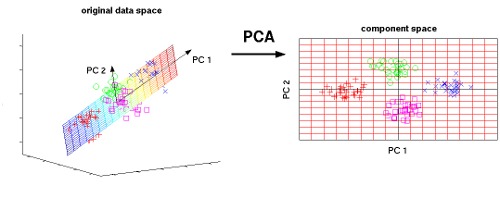

##### PCA transformation

Principal component analysis (PCA) rotates the original data space such that the axes of the new coordinate system point into the directions of highest variance of the data. The axes or new variables are termed principal components (PCs) and are ordered by variance: the first component, PC 1, represents the direction of the highest variance of the data. The direction of the second component, PC 2, represents the highest of the remaining variance orthogonal to the first component. This can be naturally extended to obtain the required number of components which together span a component space covering the desired amount of variance.
Since components describe specific directions in the data space, each component depends on certain fraction of each of the original variables: each component is a linear combination of all original variables.

##### Dimensionality reduction

Low variance can often be assumed to represent undesired background noise. The dimensionality of the data can therefore be reduced, without loss of relevant information, by extracting a lower dimensional component space covering the highest variance. Using a lower number of principal components instead of the high-dimensional original data is a common pre-processing step that often improves results of subsequent analyses such as classification. 
For visualization, the first and second component can be plotted against each other to obtain a two-dimensional representation of the data that captures most of the variance (assumed to be most of the relevant information), useful to analyze and interpret the structure of a data set.



##### An Example:

We will use r4ml.pca and will experiment to see if there are any  dependencies or co-releation between the scale (regression or continous) variables and reduce dimensions.


In [3]:
# since from the exploratory data analysis, we knew that certain
#  variables can be remove for the analysis, we will perform the pca
#  on the smaller set of features
airs_t3_tmp <- select(airs_t, names(rairs2)) # recall rairs2 from before 
airs_t3 <- as.r4ml.matrix(airs_t3_tmp)
# do the PCA analysis with 12 components
airs_t3.pca <- r4ml.pca(airs_t3, center=T, scale=T, projData=F, k=12)
  # the eigen values for each of the components which is the square of
# stddev and is equivalent to the variance
airs_t3.pca@eigen.values
 

Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, out_arg, value = <S4 object of class structure("r4ml.matrix", package = "R4ML")>):
“implicit list embedding of S4 objects is deprecated”

EigenValues1
3.98415742
3.49561102
2.35445422
1.10258944
0.99092833
0.89160441
0.50726414
0.38443082
0.15238764
0.05840663


In [4]:
# the corresponding eigenvectors are 
airs_t3.pca@eigen.vectors
 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
DepTime,-0.055485412,0.497050869,-0.08994420,0.003092499,0.007148630,-0.010095158,-0.081509373,-0.423893628,0.289633629,0.092592212,-0.6743276402,-0.071240393
CRSDepTime,-0.057305227,0.485999734,-0.13512125,-0.013008472,-0.001123042,-0.003198297,-0.083302756,-0.494638238,0.022096002,-0.078999363,0.6918756142,0.034612841
ArrTime,-0.030599161,0.444843810,-0.17465900,0.003991028,0.026744790,-0.014611505,0.195369956,0.666206174,0.518979072,0.009976401,0.1344275021,0.014661286
CRSArrTime,-0.029718576,0.481341212,-0.15334679,-0.022683738,0.021514558,0.030452979,0.087173017,0.264922283,-0.799845553,-0.037950331,-0.1502183448,0.020864919
ActualElapsedTime,0.496857914,0.037256963,-0.01480792,-0.016799134,-0.017125502,0.053546407,0.022552618,-0.014105068,0.017715776,-0.308339730,-0.0007680453,-0.218836401
CRSElapsedTime,0.494389519,0.032771281,-0.04810548,0.049874609,0.015492273,-0.053420960,-0.007202376,0.004540100,-0.018597240,0.294245434,-0.0040710952,-0.327336591
AirTime,0.493858834,0.029971944,-0.05131015,0.064565821,0.026092340,-0.062806628,-0.033313098,-0.004003344,0.012036645,-0.350468144,0.0094662531,-0.231232701
ArrDelay,0.034700759,0.183053981,0.57886198,-0.034772737,-0.006093158,0.139919803,-0.300994531,0.100701905,0.051168877,-0.526828442,-0.0858339343,0.304106859
DepDelay,0.023282495,0.192636219,0.56126171,0.113719279,0.065207035,-0.069859998,-0.391130606,0.138711809,-0.046806137,0.500473123,0.1317510732,-0.276317138
Distance,0.487980938,0.032286899,-0.06142468,0.060270337,0.034171078,-0.089075695,-0.039722975,-0.029096088,0.002177507,0.332493998,-0.0089947810,0.784200082


##### How many eigenvectors do we need?

Now the question is how many eigenvalues (and corresponding eigenvectors) we need, so that we can explain most of the variance (say 90%) of the input data. We will try to find it out in the following code:

In [5]:
sorted_evals <- sort(airs_t3.pca@eigen.values$EigenValues1, decreasing = T) 
csum_sorted_evals <- cumsum(sorted_evals)
# find the cut-off i.e the number of principal component which capture
# 90% of variance
evals_ratio <- csum_sorted_evals/max(csum_sorted_evals) 
evals_ratio

[1] 0.2846995 0.5344885 0.7027329 0.7815216 0.8523312 0.9160434 0.9522914
 [8] 0.9797621 0.9906514 0.9948250 0.9978120 1.0000000

In [7]:
pca.pc.count <- which(evals_ratio > 0.9)[1] 
pca.pc.count
 

[1] 6

Analytically we can see that we need the first six principal components. Let's also verify it intuitively or graphically. Here we will plot the PCA variance and see the overall area spanned.

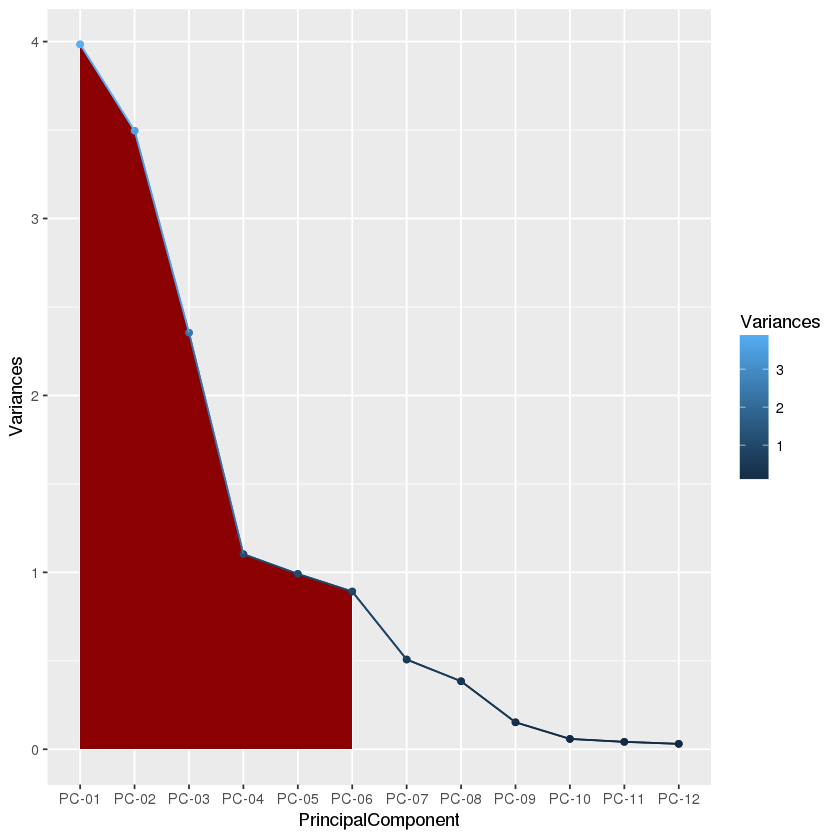

In [8]:
library(ggplot2)

pca.plot.df <- data.frame(
    index=1:length(sorted_evals),
    PrincipalComponent=sprintf("PC-%02d", 1:length(sorted_evals)),
    Variances = sorted_evals)

  pca.g1 <- ggplot(data=pca.plot.df,
         aes(x=PrincipalComponent, y=Variances, group=1, colour=Variances))
  pca.g1 <- pca.g1 + geom_point() + geom_line()
  # highlight the area containing the 90% variances

  #subset region and plot
  pca.g_data <- ggplot_build(pca.g1)$data[[1]]
  #plot the next shaded graph
  pca.g2 <- pca.g1 + geom_area(data=subset(pca.g_data, x<=pca.pc.count),
  aes(x=x, y=y), fill="red4", inherit.aes=F)
  pca.g2 <- pca.g2 + geom_point() + geom_line()
  pca.g2


### 3.4. Summary of Dimensionality Reduction.

In this subsection, we went over why dimensionality reduction is important and how R4ML helps in this task by providing a scalable PCA implementation.
We also went through an example to understand it more.

In general, using the custom algorithms, one can implement other dimensional reduction techniques like t-sne and kernel pca also.


 ## 4. Summary and next steps ...

This notebook is mostly focus on the data preparation and also on the data reduction using the PCA. In future notebooks, 
we will look into the actual modelling using the canned algorithm provided by R4ML and and also creating the custom ML models.
